In [1]:
import warnings

warnings.filterwarnings("ignore")

import os.path
import ssm
import pickle
import numpy as np
import pandas as pd
import scipy
import copy
from tqdm import tqdm

from runwise_ts_log_data import get_ts_log_data_blocked

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import to_rgba
import seaborn as sns

from sympy.utilities.iterables import multiset_permutations
from ssm.util import *
from scipy.stats import ttest_ind, wilcoxon, ranksums

In [2]:
with open('pkl/emoprox2_dataset_timeseries+inputs_MAX85.pkl','rb') as f:
    orig_df = pickle.load(f)
subj_list = sorted(orig_df['pid'].unique())
subj_list = subj_list[:] # remove first 30 subjects
orig_df = orig_df[orig_df['pid'].isin(subj_list)]

In [3]:
K = 6
D = 10
N = 85
num_subjs = 92
num_resamples = 500
M = 20

In [4]:
# from sklearn.cluster import KMeans
# from munkres import Munkres
# from sklearn.metrics.pairwise import cosine_similarity

# def reference_comms(num_states, X):
#     X = np.concatenate(X, axis=-1)
#     kmeans = KMeans(
#         n_clusters=num_states, 
#         init='k-means++', n_init=50,
#         random_state=74
#     ).fit(X=X.T)
#     print('found reference')
#     return kmeans.cluster_centers_.T # num_rois x num_comms

# def align_two_partitions(source_comms, target_comms):
#     # align source onto target
    
#     # distatnce matrix
#     Dd = 1 - cosine_similarity(target_comms.T, source_comms.T)
#     # Hungarian permutation method
#     best_pi = list(zip(*Munkres().compute(Dd)))[1]
#     source_comms = source_comms[:, best_pi]
#     return source_comms, best_pi

# def align_partitions(num_states, X):
#     comm_cntrs = reference_comms(num_states, X)
#     best_pis = []
#     for idx, comms in tqdm(enumerate(X)):
#         _, best_pi = align_two_partitions(
#             source_comms=comms, 
#             target_comms=comm_cntrs
#         )
#         best_pis.append(best_pi)
#     return best_pis

# def get_attractors(idx_resample):
#     with open(f'pkl/rslds_emoprox2_K{K}_D{D}_N{N}_{num_subjs}subjs_resample{idx_resample}.pkl','rb') as f:
#         model,_,_,_ = pickle.load(f)
#     As = model.dynamics.As
#     bs = model.dynamics.bs
#     C = model.emissions.Cs[0]
#     d = model.emissions.ds[0]
#     attractors = np.zeros((K,N))
#     for k in range(K):
#         attractors[k,:] = C@(np.linalg.inv(np.eye(D)-As[k])@bs[k])+d
#     attractors /= np.expand_dims(np.linalg.norm(attractors,axis=1),axis=1)
#     return attractors.T

# all_attractors = []    
# for idx_resample in tqdm(range(1,1+num_resamples)):
#     all_attractors.append(get_attractors(idx_resample))

# all_perms = align_partitions(K,all_attractors)

In [5]:
# def get_df(idx_resample,perm):
#     with open(f'pkl/rslds_emoprox2_K{K}_D{D}_N{N}_{num_subjs}subjs_resample{idx_resample}.pkl','rb') as f:
#         model,q,elbos,resampled_subj_list = pickle.load(f)
#     print(len(elbos))
#     model.permute(perm)
#     model.permute(np.array([1,2,4,3,5,0]))
    
#     resampled_df = []
#     for pid in resampled_subj_list:
#         resampled_df.append(orig_df[orig_df['pid']==pid])
#     resampled_df = pd.concat(resampled_df).reset_index().drop('index',axis=1)
#     df = resampled_df

#     df['continuous_states'] = [None]*df.shape[0]
#     df['discrete_states'] =[None]*df.shape[0]
#     hrflag=0
#     prox_bins = list(np.arange(M//2)/(M//2))[1:]
#     dir_bins = [0]
#     nprox = len(prox_bins)+1
#     ndir = len(dir_bins)+1
#     for idx_row in range(df.shape[0]):
#         prox = df.loc[idx_row]['proximity']
#         prox = prox - prox.min()
#         prox = prox / prox.max()
#         proxd = np.digitize(prox, bins=prox_bins)
#         dird = 1-np.digitize(df.loc[idx_row]['direction'], bins=dir_bins)
#         stim_category = (nprox*ndir-1)*dird+((-1)**dird)*proxd
#         input = np.roll(np.eye(nprox*ndir)[stim_category],shift=hrflag,axis=0)

#         y = df.loc[idx_row]['timeseries']
#         x = q.mean_continuous_states[idx_row]
#         z = model.most_likely_states(x,y,input=input)
#         df.at[idx_row,'continuous_states'] = x
#         df.at[idx_row,'discrete_states'] = z
#         prox = df.loc[idx_row]['proximity']
#         prox = prox - prox.min()
#         prox = prox / prox.max()
#         df.at[idx_row,'proximity'] = prox
    
#     return df,model

In [6]:
def get_dynamics_eigspectrum(model):
    reals = np.zeros((K,D))
    imags = np.zeros((K,D))
    norms = np.zeros((K,D))
    for idx_state in range(K):
        A = model.dynamics.As[idx_state]
        lam,_ = np.linalg.eig(A)
        reals[idx_state,:], imags[idx_state,:] = np.real(lam),np.imag(lam)
        norms[idx_state,:] = np.sqrt(reals[idx_state,:]*reals[idx_state,:]+imags[idx_state,:]*imags[idx_state,:])
    return reals,imags,np.max(norms,axis=1)

In [7]:
# all_dfs = {}
# all_models = {}
# for idx_resample in tqdm(range(1,num_resamples+1)):
#     all_dfs[idx_resample],all_models[idx_resample] = get_df(idx_resample,np.array(all_perms[idx_resample-1]))
with open(f'pkl/all_dfs_models_K{K}_D{D}_N{N}_{num_subjs}subjs_{num_resamples}resamples.pkl','rb') as f:
    all_dfs,all_models = pickle.load(f)

In [8]:
with open(f'pkl/state_masks_K{K}_D{D}_N{N}_{num_subjs}subjs_{num_resamples}resamples.pkl','rb') as f:
    state_masks = pickle.load(f)

In [9]:
all_norms = {}
for idx_resample in tqdm(range(1,num_resamples+1)):
    _, _, norms = get_dynamics_eigspectrum(all_models[idx_resample])
    state_mask = state_masks[idx_resample]
    for idx_state in range(K):
        if state_mask[idx_state] == 1:
            norms[idx_state] = np.nan
    all_norms[idx_resample] = norms

100%|██████████| 500/500 [00:00<00:00, 3601.40it/s]


In [10]:
# state_names = [f"State{i}" for i in range(1,K+1)]
# fig, axs = plt.subplots(nrows=1,ncols=K,figsize=(10,2),sharex=True,sharey=True)
# reals,imags,_ = get_dynamics_eigspectrum(model1)
# for idx_state in range(K):
#     ax = axs[idx_state]
#     real,imag = reals[idx_state,:],imags[idx_state,:]
#     ax.scatter(real,imag,s=30,marker='x',color='r',alpha=1)
#     ax.add_patch(patches.Circle((0,0),1,color='blue',fill=False))
#     ax.axhline(xmin=-2,xmax=2,y=0,color='grey',linestyle='--')
#     # ax.set_title(f'state {idx_state+1}',fontsize=15)
#     ax.set_title(f'{state_names[idx_state]}',fontsize=15)
#     ax.set_xlim([0.7,1.01])
#     ax.set_ylim([-0.23,0.23])
#     if idx_state==1: 
#         ax.set_xlabel('Real Axis',fontsize=15)
#         ax.xaxis.set_label_coords(1.0,-0.2)
#     if idx_state==0: ax.set_ylabel('Imaginary Axis',fontsize=15)

0.0
0.0
0.0
0.0
0.0


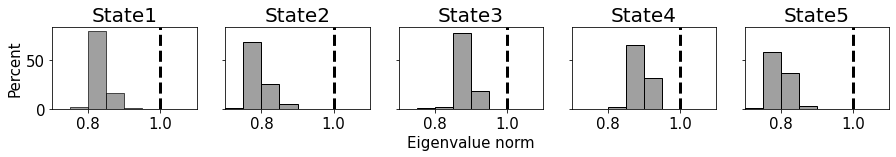

In [13]:
from matplotlib import axes
norms = np.stack(all_norms.values(),axis=0)
state_names = [f"State{i}" for i in range(1,K+1)]
# state_names = ['post-shock','shock','far','retreat','near','???']
fig, axs = plt.subplots(nrows=1,ncols=5,figsize=(15,1.5),sharex=True,sharey=True)
for i,idx_state in enumerate([0,1,2,3,4]):
    ax = axs[i]
    norm_state = norms[:,idx_state].flatten()
    norm_state = norm_state[~np.isnan(norm_state)]
    print((norm_state>=1).sum()/1000)
    sns.histplot(norm_state,binwidth=0.05,binrange=[0,1],ax=ax,kde=False,stat='percent',color='grey')
    ax.set_title(f'{state_names[idx_state]}',fontsize=20)
    ax.set_xlim([0.7,1.1])
    if idx_state==0:
        ax.set_ylabel('Percent',fontsize=15)
    if i==2:
        ax.set_xlabel('Eigenvalue norm',fontsize=15)
    ax.tick_params(axis='both',labelsize=15)
    ax.axvline(x=1,linewidth=3,color='k',linestyle='--')
fig.savefig(f'figures/fig_dynamics_matrices_eigenspectrum_K{K}_D{D}.jpg',dpi=600,bbox_inches='tight')
# fig.tight_layout()

In [12]:
import attr

def cosine(v1,v2):
    return np.dot(v1, v2)/(np.linalg.norm(v1)*np.linalg.norm(v2))

def get_attractor_centroid_corr(model,df,shuffle_z=False):
    sims = np.zeros(K)
    zs = np.hstack(list(df['discrete_states'].values)).copy()
    if shuffle_z:
        zs = np.roll(zs,shift=np.random.randint(zs.shape[0]))
    xs = np.vstack(list(df['continuous_states'].values))
    for idx_state in range(K):
        A = model.dynamics.As[idx_state]
        b = model.dynamics.bs[idx_state]
        attractor = np.linalg.inv(np.eye(D)-A) @ b
        centroid = xs[zs==idx_state,:].mean(axis=0)
        sims[idx_state] = np.corrcoef(centroid,attractor)[0,1]#cosine(attractor, centroid)
    return sims

In [13]:
all_sims = {}
all_null_sims = {}
for idx_resample in tqdm(range(1,num_resamples+1)):
    sims = get_attractor_centroid_corr(all_models[idx_resample],all_dfs[idx_resample])
    null_sims = get_attractor_centroid_corr(all_models[idx_resample],all_dfs[idx_resample],shuffle_z=True)
    state_mask = state_masks[idx_resample]
    for idx_state in range(K):
        if state_mask[idx_state] == 1:
            sims[idx_state] = np.nan
            null_sims[idx_state] = np.nan
    all_sims[idx_resample] = sims
    all_null_sims[idx_resample] = null_sims

100%|██████████| 500/500 [00:17<00:00, 28.87it/s]


RanksumsResult(statistic=17.142871546112616, pvalue=3.5526664984202255e-66)
RanksumsResult(statistic=18.3289646585706, pvalue=2.430345295384939e-75)
RanksumsResult(statistic=21.727921821835263, pvalue=5.587308282755016e-105)
RanksumsResult(statistic=20.67114506971583, pvalue=3.150182932659176e-95)
RanksumsResult(statistic=19.019398379025592, pvalue=5.891388084683222e-81)


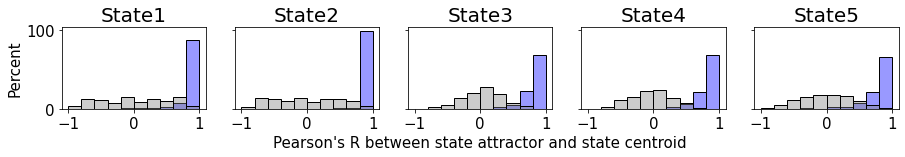

In [14]:
sims = np.stack(all_sims.values(),axis=0)
null_sims = np.stack(all_null_sims.values(),axis=0)

from scipy.stats import wilcoxon,ranksums

fig, axs = plt.subplots(nrows=1,ncols=5,figsize=(15,1.5),sharex=True,sharey=True)

for i,idx_state in enumerate([0,1,2,3,4]):
    ax = axs[i]
    sims_state = sims[:,idx_state].flatten()
    sims_state = sims_state[~np.isnan(sims_state)]
    null_sims_state = null_sims[:,idx_state].flatten()
    null_sims_state = null_sims_state[~np.isnan(null_sims_state)]
    # print(np.mean(sims_state))
    sns.histplot(sims_state,binwidth=0.2,alpha=0.4,binrange=[-1,1],ax=ax,kde=False,stat='percent',color='blue')
    sns.histplot(null_sims_state,binwidth=0.2,alpha=0.4,binrange=[-1,1],ax=ax,kde=False,stat='percent',color='grey')
    ax.set_title(f'{state_names[idx_state]}',fontsize=20)
    if idx_state==0:
        ax.set_ylabel('Percent',fontsize=15)
    if i==2:
        ax.set_xlabel("Pearson's R between state attractor and state centroid",fontsize=15)
    ax.tick_params(axis='both',labelsize=15)
    # print((sims_state>0.50).sum()/sims_state.shape[0])
    print(ranksums(sims_state,null_sims_state,alternative='greater'))
fig.savefig(f'figures/fig_attractor_centroid_similarity_K{K}_D{D}.jpg',dpi=600,bbox_inches='tight')
# fig.tight_layout()

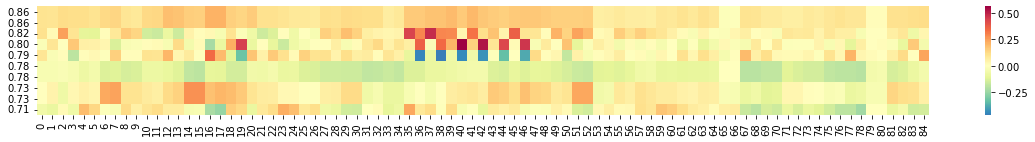

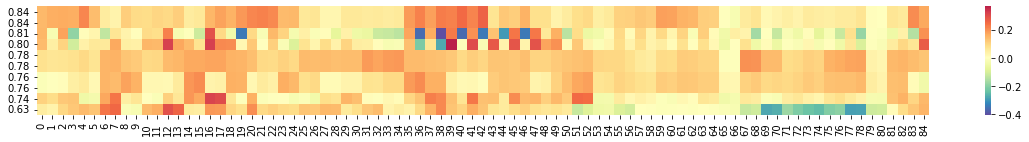

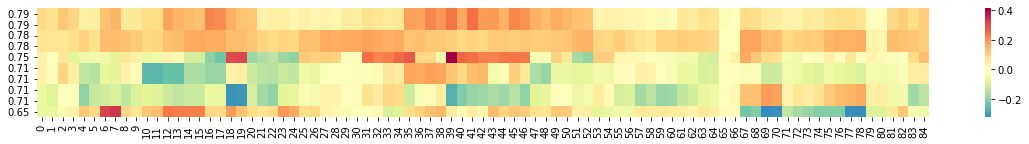

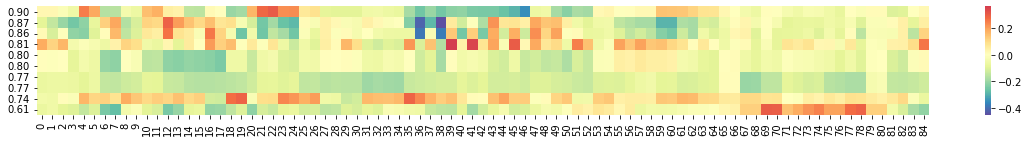

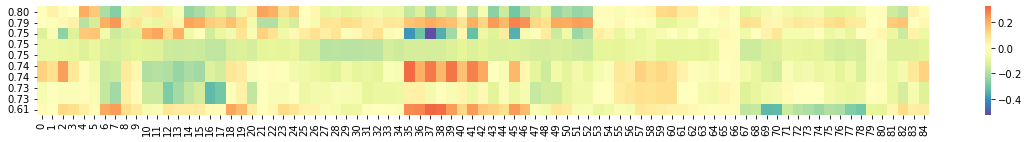

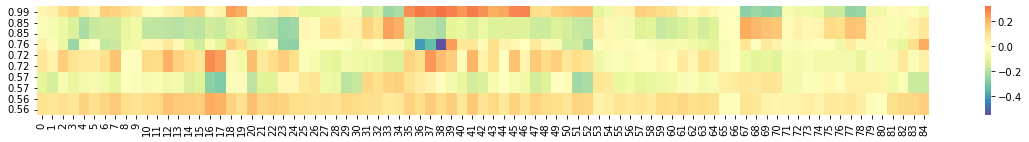

In [15]:
for k in range(K):
    A = all_models[10].dynamics.As[k]
    C = all_models[10].emissions.Cs[0]
    lam, U = np.linalg.eig(A)
    idx = np.argsort(np.abs(lam))[::-1]
    lam = lam[idx]
    U = U[:,idx]
    fig = plt.figure(figsize=(20, 2))
    ax = fig.add_subplot()
    sns.heatmap((C @ np.real(U)).T, cmap="Spectral_r", center=0, ax=ax)
    ax.set_yticks(np.arange(D)+0.5)
    ax.set_yticklabels([f'{i:.2f}' for i in np.abs(lam)],rotation=0)